In [1]:
# 1.) What was the change in price of the stock over time?
# 2.) What was the daily return of the stock on average?
# 3.) What was the moving average of the various stocks?
# 4.) What was the correlation between different stocks'?
# 5.) How much value do we put at risk by investing in a particular stock?
# 6.) How can we attempt to predict future stock behavior? (Predicting the closing price stock price of APPLE inc using LSTM)

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

# Scale the data
from sklearn.preprocessing import MinMaxScaler

# Keras with the model
from keras.models import Sequential
from keras.layers import Dense, LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score #, root_mean_squared_error

# For time stamps
from datetime import datetime

# The tech stocks we'll use for this analysis
tech_list = ['AAPL']

end = datetime.now()
start = datetime(end.year - 10, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)

company_list = [AAPL]
company_name = ["APPLE"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name


[*********************100%%**********************]  1 of 1 completed


In [3]:
# Get the stock quote
df = AAPL.copy()

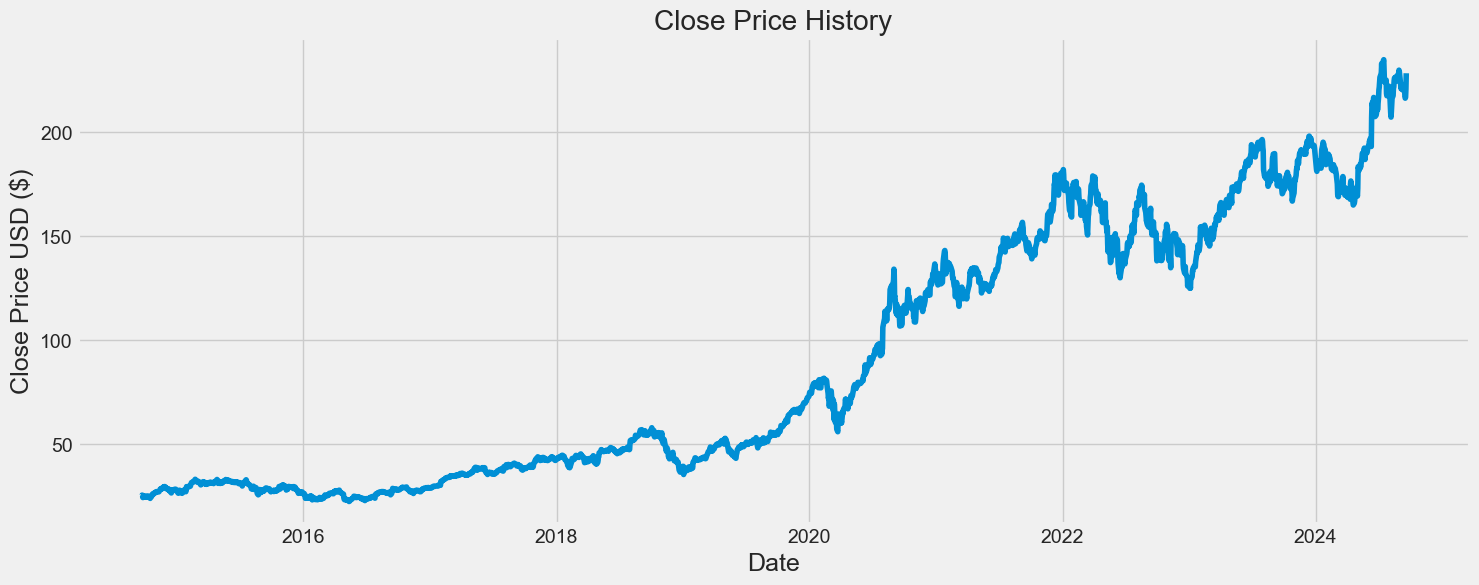

In [4]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [5]:
# Create a new dataframe with only the 'Close colum
data = df.filter(['Close'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [7]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]

# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# x_train.shape

[array([0.01250972, 0.01262751, 0.01448866, 0.01344029, 0.00886989,
       0.01226235, 0.01150847, 0.01226235, 0.01041299, 0.01126111,
       0.01093129, 0.01093129, 0.00990648, 0.01232126, 0.01258039,
       0.0122388 , 0.01115509, 0.00990648, 0.00848117, 0.00697341,
       0.0086343 , 0.0110962 , 0.01428841, 0.01490094, 0.01706835,
       0.01752775, 0.01739817, 0.01931821, 0.02002497, 0.01960092,
       0.02080242, 0.02245153, 0.02150918, 0.02181544, 0.02162697,
       0.02199214, 0.02178011, 0.02280491, 0.02463072, 0.02648008,
       0.02808208, 0.02785827, 0.02960163, 0.02865927, 0.03059109,
       0.03077956, 0.03332391, 0.03211063, 0.03375975, 0.0336773 ,
       0.02913045, 0.02861215, 0.03014348, 0.02962518, 0.02904799,
       0.02598535, 0.02801141, 0.02545527, 0.02506656, 0.02284026])]
[0.021073345966130586]

[array([0.01250972, 0.01262751, 0.01448866, 0.01344029, 0.00886989,
       0.01226235, 0.01150847, 0.01226235, 0.01041299, 0.01126111,
       0.01093129, 0.01093129, 0.0

In [8]:
firstLayer = range(32, 256, 32)
secondLayer = range(32, 128, 32)
firstDensity = range(10, 50, 10)
secondDensity = range(1, 6, 2)

# epochs = range(1, 10, 1)
ep = 1
counter = 0

colums = ['Units firstLayer', 'Units SecondLayer','firstDensity', 'secondDensity', 'Epochs' , 'MSE', 'RMSE', 'MAE', 'R2']
results = pd.DataFrame(columns=colums)

for fl in firstLayer:
    for sl in secondLayer:
        for fd in firstDensity:
            # for sd in secondDensity:
            # for ep in epochs:
            # Build the LSTM model
            model = Sequential()
            model.add(LSTM(units=fl, return_sequences=True, input_shape=(x_train.shape[1], 1)))
            model.add(LSTM(units=sl, return_sequences=False))
            model.add(Dense(fd))
            model.add(Dense(1))

            # Compile the model
            model.compile(optimizer='adam', loss='mean_squared_error')

            # Train the model
            model.fit(x_train, y_train, batch_size=1, epochs=ep)

            # Create the testing data set
            # Create a new array containing scaled values from index 1543 to 2002 
            test_data = scaled_data[training_data_len - 60: , :]

            # Create the data sets x_test and y_test
            x_test = []
            y_test = dataset[training_data_len:, :]

            for i in range(60, len(test_data)):
                x_test.append(test_data[i-60:i, 0])

            # Convert the data to a numpy array
            x_test = np.array(x_test)

            # Reshape the data
            x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

            # Get the models predicted price values 
            predictions = model.predict(x_test)
            predictions = scaler.inverse_transform(predictions)

            # Assuming y_test are the actual values and y_pred are the predicted values
            mse = mean_squared_error(y_test, predictions)
            rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
            #rmse = root_mean_squared_error(y_test, predictions)
            mae = mean_absolute_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)
 
            results.loc[counter] = [fl,  sl, fd, 1, ep, mse, rmse, mae, r2]
            counter +=1
            print('counter',counter)


4/4 [==============================] - 1s 11ms/step
counter 1
4/4 [==============================] - 1s 12ms/step
counter 2
4/4 [==============================] - 1s 12ms/step
counter 3
4/4 [==============================] - 1s 11ms/step
counter 4
4/4 [==============================] - 1s 19ms/step
counter 5
4/4 [==============================] - 1s 16ms/step
counter 6
4/4 [==============================] - 1s 18ms/step
counter 7
4/4 [==============================] - 1s 16ms/step
counter 8
4/4 [==============================] - 1s 18ms/step
counter 9
4/4 [==============================] - 1s 18ms/step
counter 10
4/4 [==============================] - 1s 20ms/step
counter 11
4/4 [==============================] - 1s 14ms/step
counter 12
4/4 [==============================] - 1s 13ms/step
counter 13
4/4 [==============================] - 1s 13ms/step
counter 14
4/4 [==============================] - 1s 14ms/step
counter 15
4/4 [==============================] - 1s 13ms/step
counter 16
4

In [9]:
display(results)

,Units firstLayer,Units SecondLayer,firstDensity,secondDensity,Epochs,MSE,RMSE,MAE,R2
0,32.0,32.0,10.0,1.0,1.0,70.689444,8.407701,6.698448,0.857562
1,32.0,32.0,20.0,1.0,1.0,32.550273,5.705285,4.690457,0.934412
2,32.0,32.0,30.0,1.0,1.0,37.008410,6.083454,4.842547,0.925429
3,32.0,32.0,40.0,1.0,1.0,43.462621,6.592619,5.123120,0.912424
4,32.0,64.0,10.0,1.0,1.0,76.626915,8.753680,7.076518,0.845599
...,...,...,...,...,...,...,...,...,...
79,224.0,64.0,40.0,1.0,1.0,31.968198,5.654043,4.659040,0.935585
80,224.0,96.0,10.0,1.0,1.0,21.386568,4.624561,3.631511,0.956907
81,224.0,96.0,20.0,1.0,1.0,55.362935,7.440627,6.054774,0.888445
82,224.0,96.0,30.0,1.0,1.0,27.766461,5.269389,4.159176,0.944051


In [10]:
import os
import pickle

results.sort_values(by=['MSE','RMSE'] ).to_csv('results 10 years.csv', decimal=',')

# if not os.path.isfile(filename):
#    with open(filename,'wb') as file:
#        pickle.dump(results, file)
#    file.close()